# get stimuli timestamp

In [5]:
# This example imports functions from the DemoReadSGLXData module to read
# analog data and convert it to volts based on the metadata information.
# The metadata file must be present in the same directory as the binary file.
# Works with both imec and nidq analog channels.
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tkinter import Tk
from tkinter import filedialog
from DemoReadSGLXData.readSGLX import readMeta, SampRate, makeMemMapRaw, GainCorrectIM, GainCorrectNI

In [6]:
# Get bin file from user
root = Tk()         # create the Tkinter widget
root.withdraw()     # hide the Tkinter root window

# Windows specific; forces the window to appear in front
root.attributes("-topmost", True)
binFullPath = Path('C:/Users/su-xiongy/Documents/realtime-analysis/data/ceph_5843_1_g0_imec0/ceph_5843_1_g0_t0.imec0.ap.bin')

root.destroy()

meta = readMeta(binFullPath)
sRate = SampRate(meta)

In [39]:
import mat73

stim_mat = mat73.loadmat('./data/ttl_stim_cam.mat')
start_idx = np.min(np.where(stim_mat['ttl'][0,:]>20000)[0])-int(sRate)
ttl_frame = stim_mat['ttl'][0,start_idx:int(start_idx+520*sRate)] # a rough frame that contains all grating patch
ttl_stim = np.where(ttl_frame>20000,30000,0)# ugly way to denoise the frame
stimuli_ontid = np.where(np.diff(ttl_stim)==30000)[0][12:]+1+start_idx
stimuli_offtid = stimuli_ontid+sRate

T_before_onset = 5
T_after_offset = 5

tStart =  stimuli_ontid[0]/sRate - T_before_onset
tEnd = stimuli_offtid[-1]/sRate + T_after_offset


ttl_target_stim = ttl_stim[int(tStart*sRate - start_idx):int(tEnd*sRate - start_idx)]

tID_stim_on = (stimuli_ontid - stimuli_ontid[0] + sRate*T_before_onset).astype(int)
tID_stim_off = (stimuli_offtid - stimuli_ontid[0] + sRate*T_before_onset).astype(int)

tStimOnset = tID_stim_on/sRate
tStimOffset = tID_stim_off/sRate


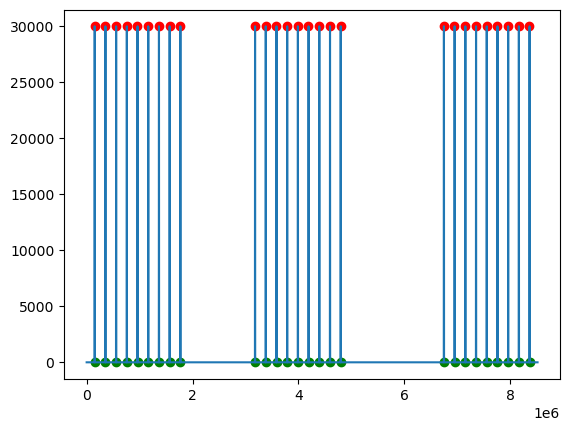

In [8]:
## crop the stimuli frame: we only care about what happened (1s before onset~1s after all stimuli delivered)  
plt.plot(ttl_target_stim)
plt.scatter(tID_stim_on, ttl_target_stim[tID_stim_on],color='red')
plt.scatter(tID_stim_off, ttl_target_stim[tID_stim_off],color='green')

# load raw data (neuropixel)

In [9]:
# Other parameters about what data to read
## only use the frame we plotted
#tStart = (stimuli_ontid[0] + start_idx - sRate)/sRate        # in seconds
#tEnd = (stimuli_offtid[-1] + start_idx + sRate)/sRate 
chanList = np.arange(80,120)    # list of channels to extract, by index in saved file

In [10]:
firstSamp = int(sRate*tStart)
lastSamp = int(sRate*tEnd)
rawData = makeMemMapRaw(binFullPath, meta)
selectData = rawData[chanList, firstSamp:lastSamp+1]

if meta['typeThis'] == 'imec':
    # apply gain correction and convert to uV
    convData = 1e6*GainCorrectIM(selectData, chanList, meta)
else:
    # apply gain correction and convert to mV
    convData = 1e3*GainCorrectNI(selectData, chanList, meta)

nChan: 385, nFileSamp: 167146363


In [11]:
convData = np.where(np.abs(convData)>200,0,convData)

In [12]:
print('first samp %d'%firstSamp)
print('start time %.2f s'%tStart)

first samp 114349309
start time 3811.64 s


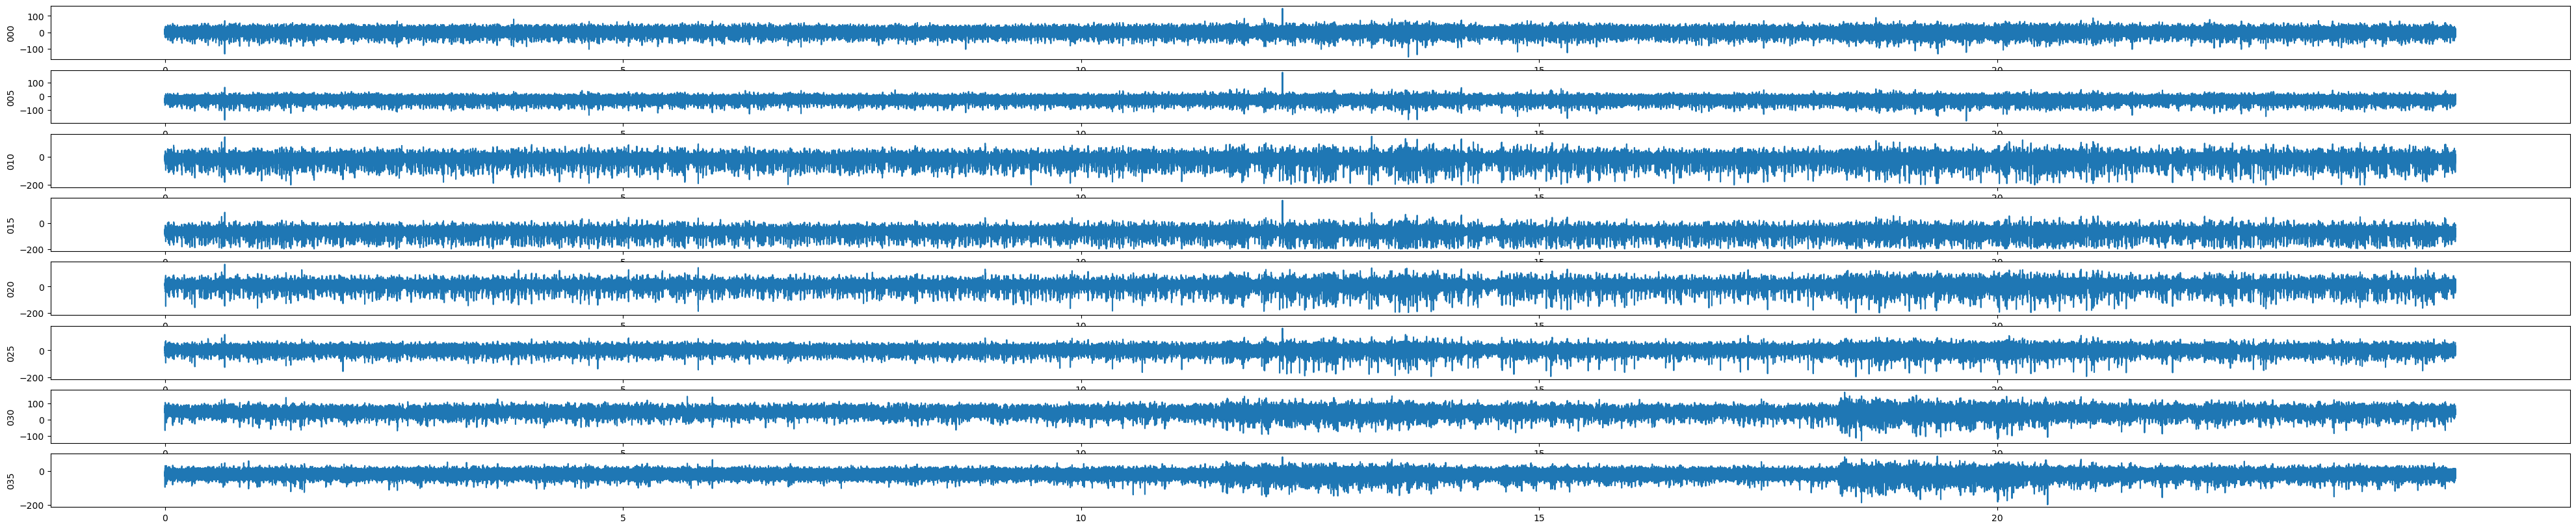

In [13]:
sample_interval = 5
fig, axes = plt.subplots(nrows=int(len(convData)/sample_interval),ncols=1,figsize = (50,10))
for i,chanid in enumerate(np.arange(0,len(convData),sample_interval)):
    axes[i].plot(convData[chanid][:int(25*sRate)])
    axes[i].set_ylabel('%03d'%chanid)
    axes[i].set_xticks(np.arange(0,25,5)*sRate,np.arange(0,25,5))
plt.savefig('rawData_timeframe.png')

# preprocess data 
## Step1: filter signal

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from sklearn.decomposition import PCA
import scipy as sp
import itertools as it
from functools import reduce

In [15]:
def filter_signal(x, fs, low, high, order=3):

    """Filter raw signal x. 
    
    Parameters
    ----------
    
    x: pd.DataFrame, (n_samples, 4)
        Each column in x is one recording channel.
    
    fs: int
        Sampling frequency.
    
    low, high: int, int
        Passband in Hz for the butterworth filter.   
        
    order: int
        The order of the Butterworth filter. Default is 3, but you should try 
        changing this and see how it affects the results.
        
    
    Return
    ------
    
    y: pd.DataFrame, (n_samples, 4)
        The filtered x. The filter delay is compensated in the output y.
        
    
    Notes
    ----
    
    1. Try exploring different filters and filter settings. More info:
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html
    
    2. The output signal should be phase-shift compensated. More info:
    https://dsp.stackexchange.com/a/19086
    
    """

    # --------------------------------------------------------------------
    # implement a suitable filter and apply it to the input data 
    # --------------------------------------------------------------------
    y = np.zeros(x.shape)
    b,a = signal.butter(order, [low ,high], btype='band', fs=fs, analog=False, output='ba')
    for ch in range(len(x)):
        y[ch] = signal.filtfilt(b, a, x[ch])
 
    return y

In [16]:
xf = filter_signal(convData, sRate, 500, 4000)

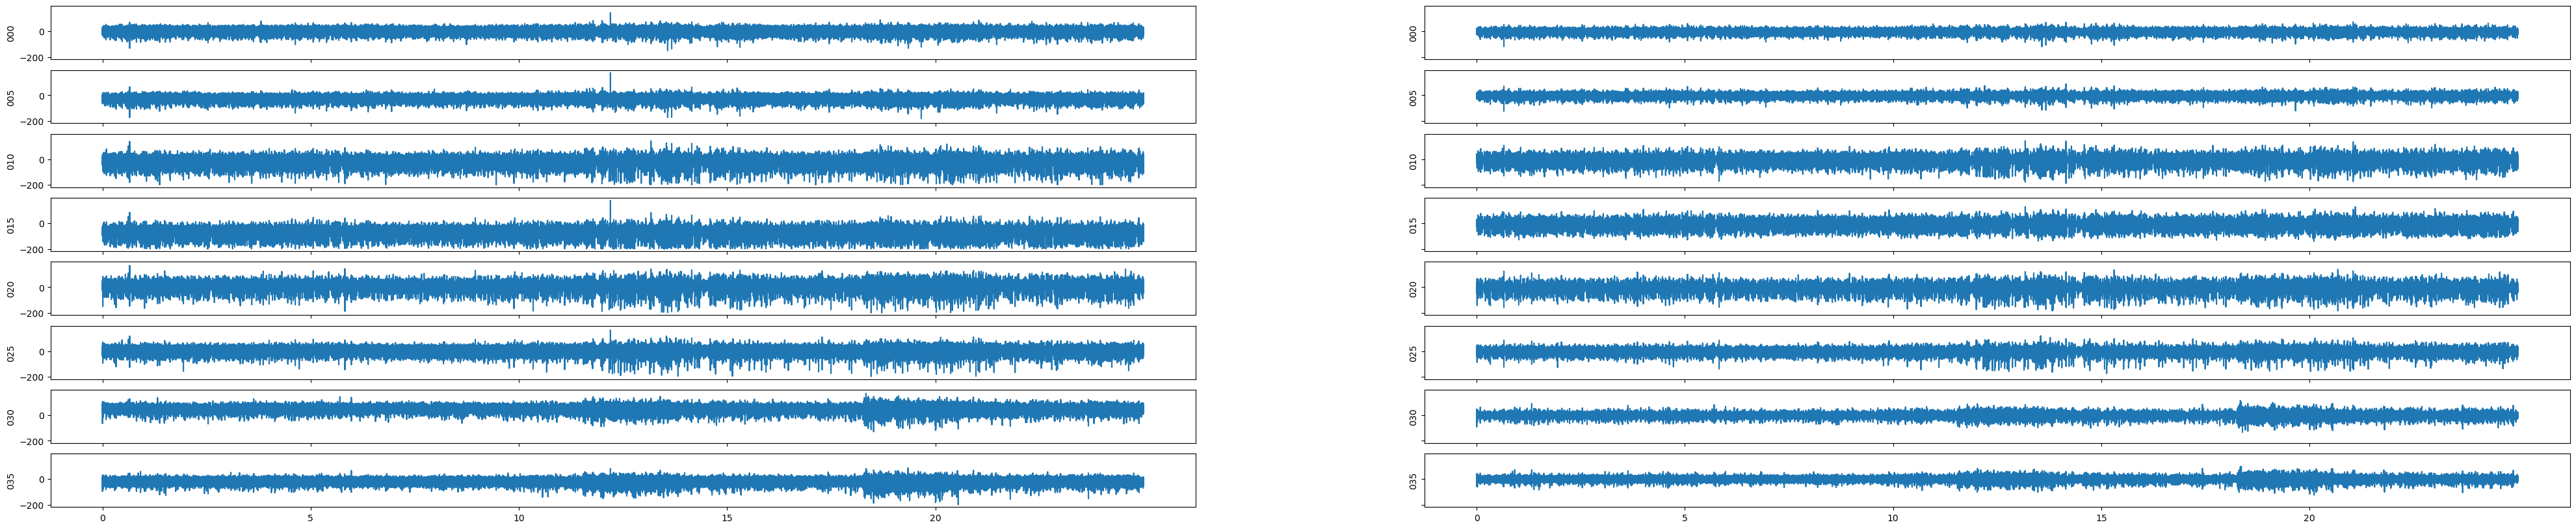

In [42]:
sample_interval = 5
fig, axes = plt.subplots(nrows=int(len(xf)/sample_interval),ncols=2,figsize = (50,10),sharex=True,sharey=True)
for i,chanid in enumerate(np.arange(0,len(xf),sample_interval)):
    axes[i,0].plot(convData[chanid][:int(25*sRate)])
    axes[i,0].set_ylabel('%03d'%chanid)
    axes[i,0].set_xticks(np.arange(0,25,5)*sRate,np.arange(0,25,5))
    axes[i,1].plot(xf[chanid][:int(25*sRate)])
    axes[i,1].set_ylabel('%03d'%chanid)
    axes[i,1].set_xticks(np.arange(0,25,5)*sRate,np.arange(0,25,5))
plt.savefig('filtered_Data_timeframe_uV.png')

## Step2: detect AP

In [17]:
def app_refractory(x, last_x, lockout):
    if x-last_x > lockout:
        last_x = x
    return last_x 

In [18]:
def detect_spikes(x, fs, N=5, lockout=10):

    """Detect spikes, in this case, the relative local minima of the signal x.
    
    Parameters
    ----------
    
    x: pd.DataFrame
        The filtered signal from Task 1.
        
    fs: int
        the sampling rate (in Hz).
        
    N: int
        An arbitrary number with which you multiply with the standard deviation
        to set a threshold that controls your false positive rate. Default is 5
        but you should try changing it and see how it affects the results.
        
    lockout: int
        a window of 'refactory period', within which there's only one spike. 
        Default is 10 but you should also try changing it. 
    
    
    Returns
    -------
    
    s: np.array, (n_spikes,)
        Spike location / index in the singal x. 
    
    t: np.array, (n_spikes,)
        Spike time in ms. By convention the time of the zeroth sample is 0 ms.
    
    thrd: float
        Threshold = -Nσ. 
        
    ----
    
    Use scipy functions to detect local minima. 
    Noted that there are four channels in signal x. 
        
    """

    # ---------------------------------
    # compute the robust s.d. 
    # ---------------------------------
    
    robustsd = np.median(np.abs(x-np.average(x))/0.6745)
    
    # --------------------------------
    # find all local minima 
    # --------------------------------
    
    lm_all = []

    for ch in range(len(x)):
        
        lm_ch = signal.find_peaks(-x[ch,:], distance = lockout)[0]
        lm_all.append(lm_ch)
    
    lm_all_clean = reduce(np.union1d, lm_all)

    
    # ---------------------------------
    # calculate the threshold 
    # ---------------------------------
    thrd = -N*robustsd
    ind_pass_thrd = np.where(np.min(x[:,lm_all_clean],axis=0)<thrd)[0]
    s_all = lm_all_clean[ind_pass_thrd]    
  
    if len(s_all)>0:
        ## delete duplicate detection from different channel
        last_lm = s_all[0]
        s_dup = np.ones(s_all.shape)*last_lm.astype(int)
        
        for i, stp in enumerate(s_all[1:]):
            s_dup[i+1] = app_refractory(stp, s_dup[i], lockout)
        s = np.unique(s_dup).astype(int)
        
        t = s/fs*1000
    else:
        s,t = [],[]
    

    return (s, t), thrd, s_all

In [19]:
(s, t), threshold, s_all = detect_spikes(xf, sRate, N=5,lockout=50)
print('from chan %03d to %03d: found %d spikes with th %.2f'%(chanList[0],chanList[-1],len(s_all),threshold))

from chan 080 to 119: found 306922 spikes with th -54.58


In [15]:
# for i in range(int(len(xf)/40)):
#     (s, t), threshold, s_all = detect_spikes(xf[i*40:i*40+40], sRate, N=8,lockout=50)
#     print('from chan %03d to %03d: found %d spikes with th %.2f'%(i*5+chanList[0],i*10+10+chanList[0],len(s_all),threshold))

from chan 080 to 090: found 12510 spikes with th -74.66
from chan 085 to 100: found 46782 spikes with th -92.75
from chan 090 to 110: found 38451 spikes with th -94.43
from chan 095 to 120: found 14082 spikes with th -90.23


In [20]:
def plot_peaks(axs, time_series, data, fs, peak_times, thr):
    time_points = (time_series*fs).astype(int)
    peak_index = (peak_times*fs).astype(int)
    axs.plot(time_series, data[time_points],linewidth=.5)
    axs.scatter(peak_times, data[peak_index], c='red',s=10)
    axs.plot(np.ones_like(data)*thr, "--", color="gray")
    axs.set_xlim((time_series[0], time_series[-1]))
    # axs.set_ylabel('V')
    return axs

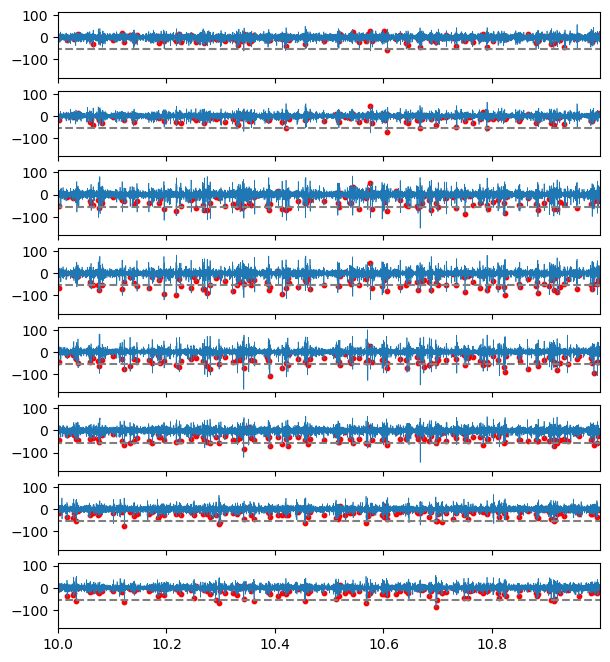

In [21]:
sample_interval = 5 
fig, axes = plt.subplots(nrows=int(len(xf)/sample_interval),ncols=1,sharey = True, sharex=True, figsize = (7,8))
start_time = 10
stop_time = 11
time_series = np.arange(start_time, stop_time, step=1/sRate)

(s, t), threshold, s_all = detect_spikes(xf, sRate, N=5,lockout=50)
peak_times = t[np.where((t<(stop_time*1000))&(t>(start_time*1000)))[0]]/1000
for i,chanid in enumerate(np.arange(0,40,sample_interval)):
    axes[i] = plot_peaks(axes[i], time_series,  xf[chanid], sRate, peak_times, threshold)

plt.savefig('detected_spks_Data_timeframe_uV.png')

# normalize data 

In [63]:
spike_times = t
bin_size = 50  # milliseconds

# Calculate the number of bins required
time_range = spike_times.max() - spike_times.min()
num_bins = np.ceil(time_range / bin_size).astype(int)

# Create bins
bins = np.arange(spike_times.min(), spike_times.max() + bin_size, bin_size)

# Use numpy.histogram to count spikes in each bin
spike_counts, _ = np.histogram(spike_times, bins=bins)


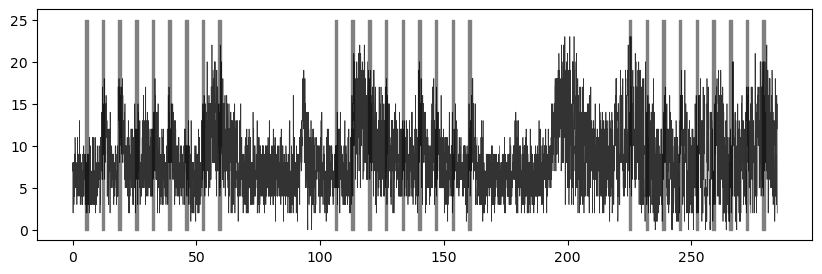

In [65]:
time_series = np.linspace(0,tEnd-tStart,len(spike_counts))
plt.figure(figsize=(10,3))
for i in range(len(tStimOnset)):
    plt.fill_betweenx([0,25], tStimOnset[i], tStimOffset[i], color="grey", alpha=1)
plt.plot(time_series, spike_counts,color='black',linewidth=.5,alpha=.8)

In [82]:
nSpk_ONset=np.zeros((len(tStimOnset),int(1000/bin_size)))
nSpk_OFFset=np.zeros((len(tStimOnset),int(1000/bin_size)))

for i in range(len(tStimOnset)):
    nSpk_ONset[i] = spike_counts[int(tStimOnset[i]*1000/bin_size):int(tStimOffset[i]*1000/bin_size)]
    nSpk_OFFset[i] = spike_counts[int((tStimOnset[i]-1)*1000/bin_size):int(tStimOnset[i]*1000/bin_size)]

In [89]:
nSpk_ONset_pos = nSpk_ONset.reshape(3,9,int(1000/bin_size))
nSpk_OFFset_pos = nSpk_OFFset.reshape(3,9,int(1000/bin_size))

In [96]:
normalized_Spk = np.sum(nSpk_ONset_pos.mean(axis=0) - nSpk_OFFset_pos.mean(axis=0),axis=1)

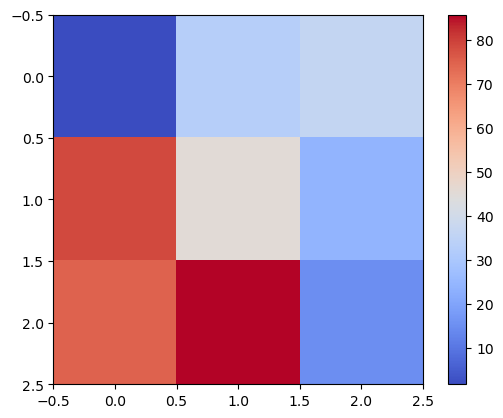

In [109]:
plt.imshow(normalized_Spk.reshape(3,3).T,cmap='coolwarm')
plt.colorbar()

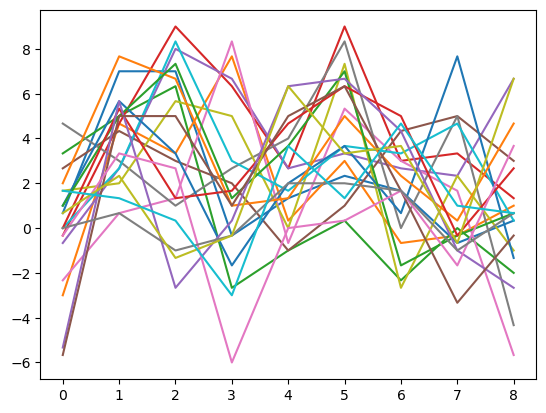

In [95]:
plt.plot(normalized_Spk)

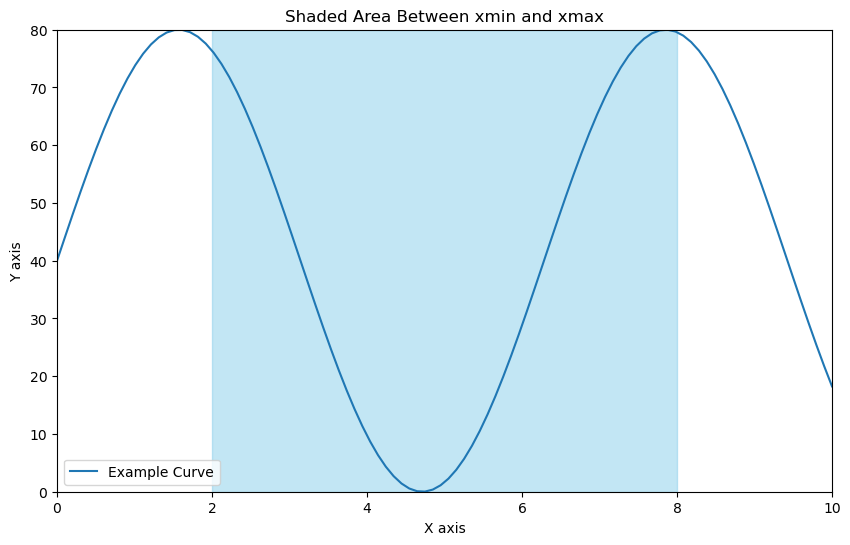

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Define your plot's dimensions and data
xmin, xmax = 2, 8
ymin, ymax = 0, 80

# Generate some example data for the background
x = np.linspace(0, 10, 100)
y = np.sin(x) * 40 + 40  # Example data

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Example Curve')

# Fill between xmin and xmax across the specified y range
plt.fill_betweenx([ymin, ymax], xmin, xmax, color='skyblue', alpha=0.5)

# Set plot limits to make the shaded area more visible
plt.xlim(0, 10)
plt.ylim(ymin, ymax)

# Add labels and title for clarity
plt.title('Shaded Area Between xmin and xmax')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.legend()

# Show the plot
plt.show()


In [ ]:
nSpk_stimOn = 

In [185]:
during_stim = np.zeros((len(stimuli_ontid),3000))
during_stim = np.zeros((len(stimuli_ontid),3000))

for sid in range(len(stimuli_ontid)):
    during_stim[sid,:] = rawData[stimuli_ontid[sid]:stimuli_ontid[sid]+3000]
    before_onset[sid,:] = rawData[stimuli_ontid[sid]-3000:stimuli_ontid[sid]]

ValueError: could not broadcast input array from shape (0,167146363) into shape (3000,)